# Numpy实现kNN K近邻算法

In [1]:
import sys
from collections.abc import Iterable
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston, load_wine, load_iris

%matplotlib inline
print("python version:", sys.version_info)
print(np.__name__, np.__version__)

python version: sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
numpy 1.17.0


https://numpy.org/devdocs/user/quickstart.html

## 1. numpy实现kNN基类

### 1.1 距离公式

manhattan曼哈顿距离：$\mathrm{d}_{12}=\sum_{k=1}^{n}\left|\mathrm{x}_{1 k}-x_{2 k}\right|$  
  
euclidean欧几里德距离：$d_{12}=\sqrt{\sum_{k=1}^{n}\left(x_{1 k}-x_{2 k}\right)^{2}}$  
  
chebyshev切比雪夫距离：$d_{12}=\max _{i}\left(\left|x_{1 i}-x_{2 i}\right|\right)$

### 1.2 Numpy的broadcast 广播机制

<img src="./imgs/1.broadcast.png">

In [2]:
class NumpyKNNBase:
    """KNN basic class with Numpy.
    
    Attributes:
        n_neighbors: A int number, number of neighbors.
        _metric: A method object, choose from {_manhattan_distance, _euclidean_distance, _chebyshev_distance}.
        _X_train: feature data for training. A np.ndarray matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train: label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be discrete value.
    """
    def __init__(self, n_neighbors=5, metric="euclidean"):
        """Init method.
    
        Args:
            n_neighbors: int, optional (default = 5), the integer must greater then 0.
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            metric: {"manhattan", "euclidean", "chebyshev"}, optional, default 'euclidean'.
        
        Raises:
            ValueError: metric value is out of options.
            AssertionError: n_neighbors value is not a integer or n_neighbors > 0. 
        """
        assert isinstance(n_neighbors, int) and n_neighbors > 0
        self.n_neighbors = n_neighbors
        if metric == "manhattan":
            self._metric = self._manhattan_distance
        elif metric == "euclidean":
            self._metric = self._euclidean_distance
        elif metric == "chebyshev":
            self._metric = self._chebyshev_distance
        else:
            raise ValueError(f'No such metric as {metric}, please option from: {"manhattan", "euclidean", "chebyshev"}')  
        self._X_train, self._y_train = [None] * 2
    
    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, data type must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape.
        
        Raises:
            AssertionError: X_train value or y_train value with a mismatched shape.
        """
        assert isinstance(X_train, Iterable) and isinstance(y_train, Iterable)
        assert len(X_train) == len(y_train)
        self._X_train = X_train if isinstance(X_train, np.ndarray) else np.array(X_train)
        self._y_train = y_train if isinstance(y_train, np.ndarray) else np.array(y_train) 
        
    def predict(self, X_test):
        """predict test data.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape, 
                or a np.ndarray array of (n_features, ) shape.
            
        Returns:
            A list for samples predictions or a single prediction.
        
        Raises:
            ValueError: X_test value with a mismatched shape.
        """
        assert isinstance(X_test, Iterable)
        X_test = X_test if isinstance(X_test, np.ndarray) else np.array(X_test)
        
        if X_test.shape == (self._X_train.shape[1], ):
            y_pred = self._predict_sample(X_test)
        elif X_test.shape[1] == self._X_train.shape[1]: 
            y_pred = []
            for sample in X_test:
                y_pred.append(self._predict_sample(sample))
        else:
            raise ValueError("Mismatched shape for X_test")
        return y_pred
        
    def _manhattan_distance(self, x):
        return np.sum(np.abs(self._X_train - x), axis=1)
    
    def _euclidean_distance(self, x):
        return np.sqrt(np.sum(np.square(self._X_train - x), axis=1))
    
    def _chebyshev_distance(self, x):
        return np.max(np.abs(self._X_train - x), axis=1)
    
    def _find_k_labels(self, sample):
        distance = self._metric(sample)
        sorted_idx = np.argsort(distance)
        k_labels = self._y_train[sorted_idx[:self.n_neighbors]]
        return k_labels
    
    def _predict_sample(self, sample):
        raise Exception("Can call predict method for NumpyKNNBase object! ")
        
    def _score_validation(self, X_test, y_test):
        assert isinstance(X_test, Iterable) and isinstance(y_test, Iterable)
        assert len(X_test) == len(y_test)
        X_test = X_test if isinstance(X_test, np.ndarray) else np.array(X_test)
        y_test = y_test if isinstance(y_test, np.ndarray) else np.array(y_test)
        return X_test, y_test

## 2. numpy实现kNN Classifier

In [3]:
class NumpyKNNClassifier(NumpyKNNBase):
    """kNN Classifier with numpy, explicitly inherits from NumpyKNNBase already.
    
    Attributes:
        n_neighbors: A int number, number of neighbors.
        _metric: A method object, choose from {_manhattan_distance, _euclidean_distance, _chebyshev_distance}.
        _X_train: feature data for training. A np.ndarray matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train: label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be discrete value.
    """

    def score(self, X_test, y_test):
        """Use test dataset to evaluate the trained model.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape.
            y_test: A np.ndarray array of (n_samples, ) shape. data type must be
                discrete value.
        Returns:
            return accuracy, a float number. accuracy = correct_count / y_test.shape[0]
        """
        X_test, y_test = self._score_validation(X_test, y_test)
        
        y_pred = self.predict(X_test)
        correct_count = np.sum(y_pred == y_test)
        accuracy = correct_count / y_test.shape[0]
        return accuracy
    
    def _predict_sample(self, sample):
        k_labels = self._find_k_labels(sample)
        pred = Counter(k_labels).most_common(1)[0][0]
        return pred

### wine红酒数据集

https://scikit-learn.org/stable/datasets/index.html#wine-dataset

In [4]:
X_data, y_data = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=1, shuffle=True)

In [5]:
clf = NumpyKNNClassifier()
clf.fit(X_train, y_train)

In [6]:
clf.score(X_test, y_test)

0.6888888888888889

### iris数据集验证算法

In [7]:
X_data, y_data = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=1, shuffle=True)
clf = NumpyKNNClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

### 归一化特征值 normalization

https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

#### min-max normalization  最小-最大值归一化

将特征缩放到[0, 1]之间。  
  
公式：$X\_scaler = \frac{X - min}{max - min}$

#### 再战红酒数据集

In [8]:
X_data, y_data = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=1, shuffle=True)

from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
X_train

array([[1.305e+01, 1.770e+00, 2.100e+00, ..., 8.800e-01, 3.350e+00,
        8.850e+02],
       [1.233e+01, 9.900e-01, 1.950e+00, ..., 1.060e+00, 2.310e+00,
        7.500e+02],
       [1.376e+01, 1.530e+00, 2.700e+00, ..., 1.250e+00, 3.000e+00,
        1.235e+03],
       ...,
       [1.349e+01, 1.660e+00, 2.240e+00, ..., 9.800e-01, 2.780e+00,
        4.720e+02],
       [1.293e+01, 2.810e+00, 2.700e+00, ..., 7.700e-01, 2.310e+00,
        6.000e+02],
       [1.305e+01, 1.650e+00, 2.550e+00, ..., 1.120e+00, 2.510e+00,
        1.105e+03]])

In [11]:
X_train = scaler.fit_transform(X_train) # 等同于 X_train = scaler.fit(X_train).transform(X_train)

In [12]:
scaler.data_min_, scaler.data_max_

(array([1.103e+01, 9.000e-01, 1.700e+00, 1.120e+01, 7.000e+01, 9.800e-01,
        3.400e-01, 1.300e-01, 4.100e-01, 1.280e+00, 5.500e-01, 1.270e+00,
        2.780e+02]),
 array([1.483e+01, 5.800e+00, 3.230e+00, 2.850e+01, 1.620e+02, 3.880e+00,
        5.080e+00, 6.300e-01, 3.580e+00, 1.300e+01, 1.710e+00, 4.000e+00,
        1.680e+03]))

In [13]:
X_train

array([[0.53157895, 0.17755102, 0.26143791, ..., 0.28448276, 0.76190476,
        0.43295292],
       [0.34210526, 0.01836735, 0.16339869, ..., 0.43965517, 0.38095238,
        0.33666191],
       [0.71842105, 0.12857143, 0.65359477, ..., 0.60344828, 0.63369963,
        0.68259629],
       ...,
       [0.64736842, 0.15510204, 0.35294118, ..., 0.37068966, 0.55311355,
        0.13837375],
       [0.5       , 0.38979592, 0.65359477, ..., 0.18965517, 0.38095238,
        0.2296719 ],
       [0.53157895, 0.15306122, 0.55555556, ..., 0.49137931, 0.45421245,
        0.58987161]])

In [14]:
X_test = scaler.transform(X_test)

In [15]:
cls = NumpyKNNClassifier()
cls.fit(X_train, y_train) 
cls.score(X_test, y_test)

0.9777777777777777

## 3. numpy实现kNN Regressor

In [16]:
class NumpyKNNRegressor(NumpyKNNBase): 
    """kNN NumpyKNNRegressor with numpy, explicitly inherits from NumpyKNNBase already.
    
    Attributes:
        n_neighbors: A int number, number of neighbors.
        _metric: A method object, choose from {_manhattan_distance, _euclidean_distance, _chebyshev_distance}.
        _X_train: feature data for training. A np.ndarray matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train: label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be discrete value.
    """
    
    def score(self, X_test, y_test):
        """Use test dataset to evaluate the trained model.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape.
            y_test: A np.ndarray array of (n_samples, ) shape. data type must be
                discrete value.
        Returns:
            return R^2, R^2 = 1 - u / v. u = sum((y_pred - y_true)^2), v = sum((y_true - y_true_mean)^2)
        """
        X_test, y_test = self._score_validation(X_test, y_test)
        
        y_pred = self.predict(X_test)
        y_true_mean = np.mean(y_test, axis=0)
        u = np.sum(np.square(y_pred - y_test))
        v = np.sum(np.square(y_test - y_true_mean))
        r_squared = 1 - u / v
        return r_squared
    
    def _predict_sample(self, sample):
        k_labels = self._find_k_labels(sample)
        pred = np.mean(k_labels, axis=0)
        return pred

#### 波士顿房价数据集

https://scikit-learn.org/stable/datasets/index.html#boston-dataset

In [17]:
X_data, y_data = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True, random_state=1)

rgs = NumpyKNNRegressor()
rgs.fit(X_train, y_train)

In [18]:
rgs.score(X_test, y_test)

0.5281871748119744

In [19]:
def show_regressor_pred(pred, y_test, y_train, x_magnification=1, y_magnification=1):
    plt.figure(figsize=(18 * x_magnification, 9 * y_magnification))
    plt.plot(range(y_test.shape[0]), y_test, label="true")
    plt.plot(range(y_test.shape[0]), pred, label="prediction")
    plt.scatter(range(y_test.shape[0]), [np.mean(y_train)] * y_test.shape[0], label="mean", s=2, c="green")
    plt.xlabel("test sample index")
    plt.ylabel("label unit")
    plt.legend()
    plt.show()

In [20]:
pred = rgs.predict(X_test)

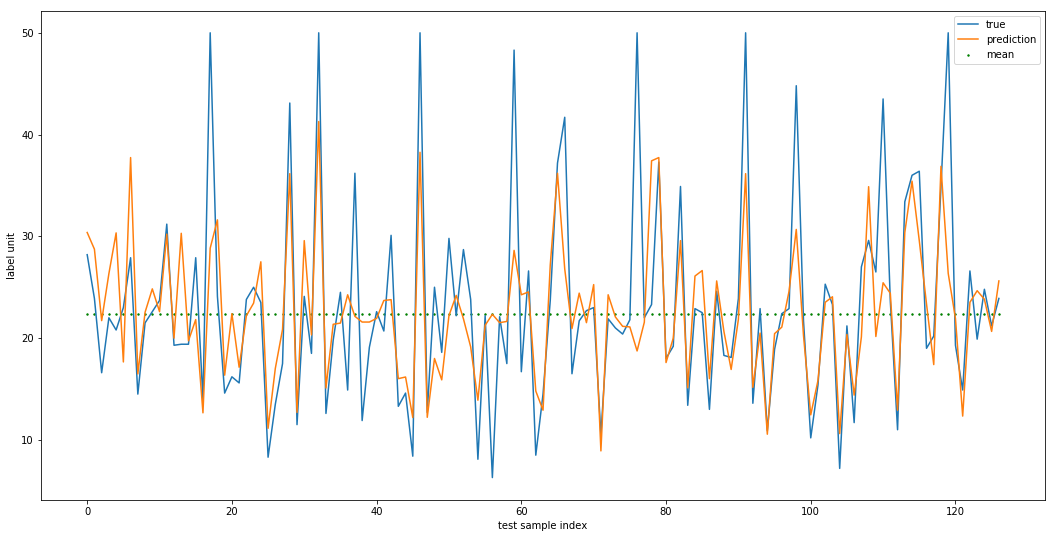

In [21]:
show_regressor_pred(pred, y_test, y_train)

## 4. 总结

### 4.1 knn实现步骤

1. 求X_test和X_train的距离
    > 求距离的方式：manhattan曼哈顿距离、euclidean欧几里德距离、chebyshev切比雪夫距离
2. 距离排序
3. 找出top k的label
4. top k label投票或求均值，得出预测值

### 4.2 python面向对象

1. 封装、继承、多态
2. \_\_new\_\_(cls) —— python类真正的构造方法

### 4.3 numpy API的使用

1. np.square()
2. np.sqrt()
3. np.abs()
4. np.mean(a, axis)
5. np.sum(a, axis)
6. np.argsort(a, axis)  
7. numpy的broadcast 广播机制  

## 作业

1. 手敲代码，使用numpy实现kNN Classifier和kNN Regressor。至少写两遍，第一遍照着敲，第二遍自己敲。不要忽略写注释文档！！！  
2. 了解其他求距离的方法及公式，并实现添加到NumpyKNNBase类中。思考其中的哪些距离方法不适合kNN？
3. 使用numpy实现min-max normalization 最小-最大值归一化。
4. 了解其他数据归一化的方法及公式，以及在sklearn中的实现。  
5. 用numpy实现train_test_split

## 相关链接  
  
<a href="./01.1.kNN.ipynb" style=""> 1.1 kNN k近邻算法原理 </a>  
<a href="./01.2.kNN-sklearn.ipynb" style=""> 1.2 sklearn中使用kNN做分类、回归任务 </a>  
  
<a href="./01.4.kNN-tf2.ipynb"> 1.4 TensorFlow2实现kNN分类和回归 </a>  
<a href="./01.5.kNN-torch1.ipynb"> 1.5 Pytorch1实现kNN分类和回归 </a>  

## 项目源码  

https://github.com/LossJ     
进入后点击Statistic-Machine-Learning  